# **CSCI 4967 Projects in AI/ML HW6**

**Spring 2024**

*Author: Yuming (Tao) Xie*

### Task 1:

In [1]:
import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
from datasets import load_metric

df = pd.read_json("/content/bloomberg_quint_news.json")

In [2]:
print(df.head())
print(df.isnull().sum())
df_cleaned = df.dropna(subset=['title', 'short_description'])
df_cleaned.reset_index(drop=True, inplace=True)

                                                 url  \
0  https://www.bloombergquint.com/markets/all-you...   
1  https://www.bloombergquint.com/business/bridge...   
2  https://www.bloombergquint.com/markets/stocks-...   
3  https://www.bloombergquint.com/research-report...   
4  https://www.bloombergquint.com/business/cp-rai...   

                                               title  \
0  All You Need To Know Going Into Trade On Septe...   
1  Bridgestone CEO Backs Safe Tokyo Olympics, Dia...   
2  Stocks To Watch: HCL Tech, Cyient, M&M Financi...   
3  Localised Lockdowns Cannot But Impinge On Econ...   
4  CP Rail Wins Regulator Exemption From Tougher ...   

                                   short_description  \
0  Stocks in the news, big brokerage calls of the...   
1  Bridgestone CEO Backs Safe Tokyo Olympics, Dia...   
2     Here are the stocks to watch in trade today...   
3  Localised Lockdowns Cannot But Impinge On Econ...   
4  CP Rail Wins Regulator Exemption From Tough

In [3]:
def tokenize(text):
    tokens = re.split(r'\W+', text)
    return [token.lower() for token in tokens if token]

all_titles = " ".join(df_cleaned['title'].apply(tokenize).apply(" ".join))
all_descriptions = " ".join(df_cleaned['short_description'].apply(tokenize).apply(" ".join))

title_word_freq = Counter(all_titles.split())
description_word_freq = Counter(all_descriptions.split())

print(title_word_freq.most_common(10))
print(description_word_freq.most_common(10))

[('to', 1902), ('s', 1837), ('in', 1224), ('the', 1009), ('for', 873), ('on', 745), ('of', 717), ('a', 648), ('u', 575), ('is', 539)]
[('to', 2091), ('s', 1927), ('the', 1684), ('in', 1439), ('of', 971), ('for', 918), ('a', 834), ('on', 738), ('is', 617), ('u', 575)]


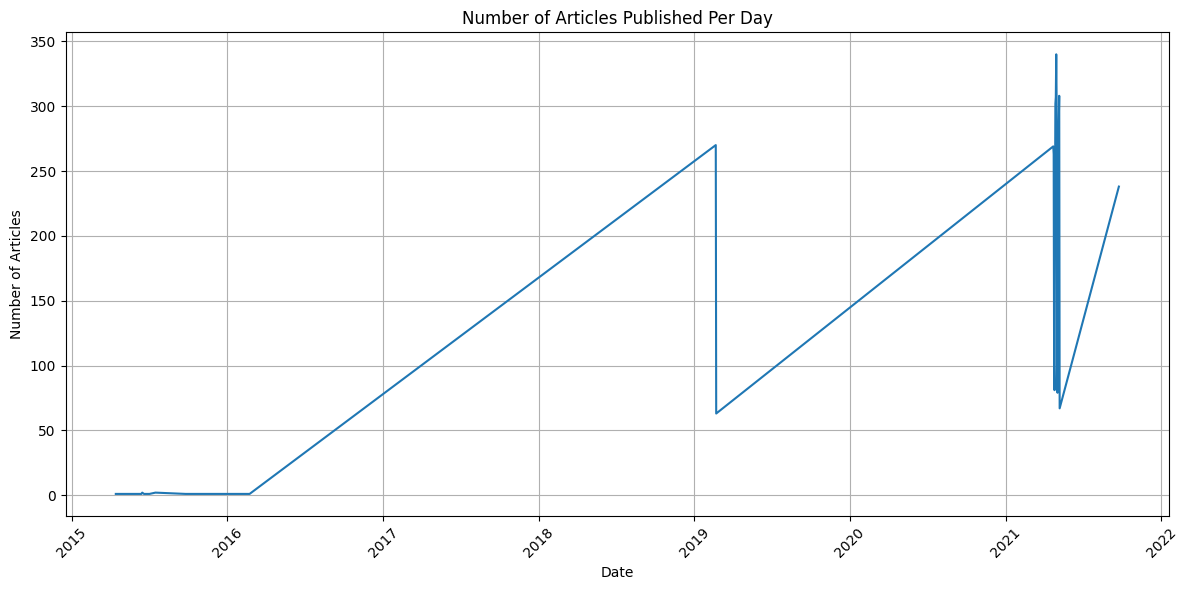

In [4]:
df_cleaned['date_created'] = pd.to_datetime(df_cleaned['date_created'], format='%d %b %Y, %I:%M %p IST')

articles_per_day = df_cleaned['date_created'].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 6))
articles_per_day.plot(kind='line')
plt.title('Number of Articles Published Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
X = df_cleaned['raw_description']
y = df_cleaned['short_description']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
train_encodings = tokenizer(X_train.to_list(), max_length=512, truncation=True, padding='max_length', return_tensors="pt")
test_encodings = tokenizer(X_test.to_list(), max_length=512, truncation=True, padding='max_length', return_tensors="pt")
train_labels = tokenizer(y_train.to_list(), max_length=128, truncation=True, padding='max_length', return_tensors="pt")
test_labels = tokenizer(y_test.to_list(), max_length=128, truncation=True, padding='max_length', return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
class NewsSummaryDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [8]:
train_dataset = NewsSummaryDataset(train_encodings, train_labels)
test_dataset = NewsSummaryDataset(test_encodings, test_labels)

In [9]:
bleu_metric = load_metric('bleu', trust_remote_code=True)
rouge_metric = load_metric('rouge', trust_remote_code=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = [[label] for label in tokenizer.batch_decode(labels, skip_special_tokens=True)]
    bleu_result = bleu_metric.compute(predictions=[decoded_preds], references=decoded_labels)
    rouge_result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {
        'bleu': bleu_result['bleu'],
        'rouge1': rouge_result['rouge1'].mid.fmeasure,
        'rouge2': rouge_result['rouge2'].mid.fmeasure,
        'rougeL': rouge_result['rougeL'].mid.fmeasure,
        'rougeLsum': rouge_result['rougeLsum'].mid.fmeasure,
    }
    return result

<ipython-input-9-0ca4934e7356>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric('bleu', trust_remote_code=True)


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=50,
    weight_decay=0.1,
    logging_dir='./logs',
    evaluation_strategy="no",
    save_strategy="epoch",
    load_best_model_at_end=False,
    fp16=False,
    gradient_accumulation_steps=2,
    logging_steps=100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
<ipython-input-7-d82134d6fe98>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-7-d82134d6fe98>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Step,Training Loss


### Task 2

We can model the Go game as a MDP as follows:

- **State Space**: Each state can be defined as the configuration of stones on the board. Given a standard 19x19 Go board, each intersection can be empty, have a black stone, or have a white stone, which is 3^361 states.

- **Action Space**: For any given state, the actions include placing one's stone on any empty point of the board, except those moves that violate Go rules. Hence, the size of the action space varies as the game progresses but is at most the number of intersections on the board.

- **Transition Model**: The outcome of each move is deterministic as the change on the board after placing a stone is predictable. But we need to add uncertainty due toi the opponent's behavior and corresponding responses.

- **Rewards**: The winner receives a positive reward, while the loser receives a negative reward. The intermediate rewards are given when controlling a larger portion of the board, capturing more of the opponent's stones, and improving one's own survivability.

### Task 3

AlphaGo and its subsequent versions (like AlphaGo Zero and AlphaZero) are the most notable examples. They learned Go strategies from scratch by playing games against themselves, eventually achieving levels beyond top human professional players.

- **Problem Addressed**: The main challenge in Go is the game's vast decision space and the complexity of its rules. The application of reinforcement learning here is to develop algorithms that can learn how to choose the optimal action in any given state, thereby autonomously learning and improving Go skills without the need for human knowledge input.

- **Open-source Project**: AlphaGo Zero is a famous project that applied deep reinforcement learning techniques. While its detailed implementation is not entirely open source, Google DeepMind has published numerous research papers related to it [1]. These papers provide the theoretical basis and insights for researchers in Go and other fields to implement such types of algorithms. Based on this, several open-source projects have attempted to replicate or are inspired by AlphaGo Zero's approach, fostering further innovation and development in applying reinforcement learning to Go and beyond [2].

### References:

[1] Holcomb, Sean D., et al. "Overview on deepmind and its alphago zero ai." Proceedings of the 2018 international conference on big data and education. 2018.

[2] Lapan, Maxim. Deep Reinforcement Learning Hands-On: Apply modern RL methods, with deep Q-networks, value iteration, policy gradients, TRPO, AlphaGo Zero and more. Packt Publishing Ltd, 2018.